In [1]:
!pip install xgboost

Run match prediction algorithms with network metrics included.

In [1]:
import pandas as pd # data manipulation\n",
pd.options.mode.chained_assignment = None  # default='warn'\n",
import numpy as np #  mathematical support for large, multi-dimensional arrays and matrices\n",
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import re
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

import collections
from matplotlib.patches import Arc
import math
#import xgboost
#import dtreeviz
from sklearn.model_selection import KFold


In [2]:

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

# allDone()


### Set Directory

In [3]:
try:
    os.chdir('/kaggle/input/football-event-data')
except:
    pass

In [4]:
try:
    os.chdir('/group/interns202010/jmakins/Data')
except:
    pass

In [5]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/Players')
except:
    pass

In [6]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/matches/')
except:
    pass
os.listdir()

['matches_World_Cup.json',
 'matches_Italy.json',
 'matches_Germany.json',
 'matches_England.json',
 'matches_France.json',
 'matches_Spain.json',
 'matches_European_Championship.json']

In [7]:
England = pd.read_json('matches_England.json')
France = pd.read_json('matches_France.json')
Italy = pd.read_json('matches_Italy.json')
Spain = pd.read_json('matches_Spain.json')
Germany = pd.read_json('matches_Germany.json')

England['Country'] = 'England'
France['Country'] = 'France'
Italy['Country'] = 'Italy'
Spain['Country'] = 'Spain'
Germany['Country'] = "Germany"

In [8]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/')
except:
    pass

Teams = pd.read_json('teams.json')
Players = pd.read_json('players.json')

In [9]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/events/')
except:
    pass


### Data Cleaning

In [10]:
Matches = pd.concat([England, France, Italy, Spain, Germany], ignore_index=True)

In [11]:
Matches.drop(['duration'], inplace=True, axis =1) # removing groupName variable from World Cups

In [12]:
Players.drop(["passportArea"], inplace = True, axis = 1)

In [13]:
Players = Players.rename(columns ={'wyId': 'playerId'}) # rename for convenience

In [14]:
Teams = Teams.rename(columns = {'wyId': 'teamId'})
Players = Players.rename(columns = {'currentTeamId': 'teamId'})
Players = pd.merge(Players,Teams[['teamId', 'officialName']], on = 'teamId').rename(columns = {'officialName': 'clubName'})

In [15]:
Players['Position'] = Players.role.apply(pd.Series)['code3'].values

In [16]:
Players['birthCountry'] = Players.birthArea.apply(pd.Series)['name'].values

In [17]:
Players.drop(["birthArea", 'role'], inplace = True, axis = 1)

### Manipulate Match Data

In [18]:
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match

In [19]:
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match
homeTeam, awayTeam = [],[]
for x in teams:
    homeTeam.append(x[0])
    awayTeam.append(x[1])

In [20]:
# add columns for additional match statistics
Matches["homeManagerId"] = None
for name in ["Score", "ScoreHT", "ScoreET", "ScoreP"]:
    colname = "home" + name
    colname2 = "away" + name
    Matches[colname] = None
    Matches[colname2] = None

In [21]:
# parse Home and Away teams as features from nest dictionary
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match
homeTeam, awayTeam = [],[]
for game, team in enumerate(teams):
    if Matches.teamsData[game:game+1][game][team[0]]['side'] == 'home':
        homeTeam.append(team[0])
        awayTeam.append(team[1])
    else:
        awayTeam.append(team[0])
        homeTeam.append(team[1])

In [22]:
def get_team_stats(df, team): # function to parse team match stats from dictionary embedded in column teamsData from the Matches dataframe
    
    Bench, Starters, Manager, Score, ScoreHT, ScoreET, ScoreP, teamId = [],[],[],[],[],[],[],[]
    
    for game in range(0, len(df)):

        Bench.append(list(pd.DataFrame.from_dict(df.teamsData[game][team[game]]['formation']['bench'])['playerId']))
        Starters.append(list(pd.DataFrame.from_dict(df.teamsData[game][team[game]]['formation']['lineup'])['playerId']))
        Manager.append(df.teamsData[game][team[game]]['coachId'])
        Score.append(df.teamsData[game][team[game]]['score'])
        ScoreHT.append(df.teamsData[game][team[game]]['scoreHT'])
        ScoreET.append(df.teamsData[game][team[game]]['scoreET'])
        ScoreP.append(df.teamsData[game][team[game]]['scoreP'])
        teamId.append(df.teamsData[game][team[game]]['teamId'])
    
    return Bench, Starters, Manager, Score, ScoreHT, ScoreET, ScoreP, teamId

homeBench, homeStarters, homeManager, homeScore, homeScoreHT, homeScoreET, homeScoreP, homeTeamId = get_team_stats(Matches, homeTeam)
awayBench, awayStarters, awayManager, awayScore, awayScoreHT, awayScoreET, awayScoreP, awayTeamId = get_team_stats(Matches, awayTeam)


In [23]:
# Automating Bench Line Up Column Generation

homeColNames = []
for num in range(1,14): # add columns for home bench playerId
     homeColNames.append("homeBenchPlayer" + str(num))
        
awayColNames = []
for num in range(1,14): # add columns for away bench playerId
    awayColNames.append("awayBenchPlayer" + str(num))
    


In [24]:
# Inspecting bench counts as during errror handling reveals some matches had bench sizes of between 8 and 13 for certain fixtures
import collections
collections.Counter(list(map(lambda x: len(x), homeBench)))

Counter({7: 1425, 6: 18, 5: 1, 8: 5, 12: 205, 10: 49, 11: 101, 9: 21, 13: 1})

In [25]:
# Adding Bench Line Ups to DataFrame

homeBench2 = pd.DataFrame(homeBench,
     columns=homeColNames)
awayBench2 = pd.DataFrame(awayBench,
     columns=awayColNames)


In [26]:
# Automating Starting Line Up Column Generation

homeColNames =[]
for num in range(1,12): # add columns for starting playerId
     homeColNames.append("homePlayer" + str(num))
        
awayColNames = []
for num in range(1,12): # add columns for starting playerId
    awayColNames.append("awayPlayer" + str(num))


In [27]:
# Joining starting line ups, benches to matches dataframe

homeStarters2 = pd.DataFrame(homeStarters,
     columns=homeColNames)
awayStarters2 = pd.DataFrame(awayStarters,
     columns=awayColNames)

Matches = Matches.join([homeStarters2, awayStarters2, homeBench2, awayBench2])


In [28]:
# add individual columns of match data
Matches['homeManager'] = homeManager
Matches['homeScore'] = homeScore
Matches['homeScoreHT'] = homeScoreHT
Matches['homeScoreET'] = homeScoreET
Matches['homeScoreP'] = homeScoreP
Matches['homeTeamId'] = homeTeamId
Matches['awayManager'] = awayManager
Matches['awayScore'] = awayScore
Matches['awayScoreHT'] = awayScoreHT
Matches['awayScoreET'] = awayScoreET
Matches['awayScoreP'] = awayScoreP
Matches['awayTeamId'] = awayTeamId

In [29]:
Matches.drop(["teamsData"], inplace = True, axis = 1)

In [30]:
# Classify Match Result as W, L or D for teams
conditions = [
    (Matches['winner'] == 0),
    (Matches['winner'] == Matches['awayTeamId']),
    (Matches['winner'] == Matches['homeTeamId'])
    ]

# create a list of the values we want to assign for each condition
values = [0, -1, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
Matches['Result'] = np.select(conditions, values)

In [31]:
Matches["date"] = pd.to_datetime(Matches['dateutc']).dt.date # create a date column for Matches dataframe

In [32]:
Matches["time"] = pd.to_datetime(Matches['dateutc']).dt.time # create a time column for Matches dataframe

In [33]:
# Prelim Dimensionality Reduction
cols2Drop = ['status', 'roundId', 'gameweek', 'dateutc', 'label', 'referees', 'homeManagerId', 'seasonId']
Matches.drop(cols2Drop, inplace=True, axis =1)
Matches.drop(['winner', 'date', 'time'], inplace = True, axis =1)

In [34]:
Matches.rename(columns={'wyId':'matchId'}, inplace=True)

In [35]:
Matches = Matches.fillna(0) # fill bench7players with Ids = 0 in order to prevent program crashing

### Player Aggs

In [36]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/New_Player_Aggs_live')

In [37]:
# path = os.getcwd()

Player_Aggs_live10 = pd.read_csv('Player_Aggs_live10')
Player_Aggs_live10.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live20= pd.read_csv('Player_Aggs_live20')
Player_Aggs_live20.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live30= pd.read_csv('Player_Aggs_live30')
Player_Aggs_live30.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live40= pd.read_csv('Player_Aggs_live40')
Player_Aggs_live40.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live50= pd.read_csv('Player_Aggs_live50')
Player_Aggs_live50.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live60= pd.read_csv('Player_Aggs_live60')
Player_Aggs_live60.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live70= pd.read_csv('Player_Aggs_live70')
Player_Aggs_live70.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live80= pd.read_csv('Player_Aggs_live80')
Player_Aggs_live80.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live90= pd.read_csv('Player_Aggs_live90')
Player_Aggs_live90.drop(["Unnamed: 0"], axis=1, inplace=True)

In [38]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/')

Met_Aggs_live10 = pd.read_json('MetAggs/Met_live_10')
Met_Aggs_live20 = pd.read_json('MetAggs/Met_live_20')
Met_Aggs_live30 = pd.read_json('MetAggs/Met_live_30')
Met_Aggs_live40 = pd.read_json('MetAggs/Met_live_40')
Met_Aggs_live50 = pd.read_json('MetAggs/Met_live_50')
Met_Aggs_live60 = pd.read_json('MetAggs/Met_live_60')
Met_Aggs_live70 = pd.read_json('MetAggs/Met_live_70')
Met_Aggs_live80 = pd.read_json('MetAggs/Met_live_80')
Met_Aggs_live90 = pd.read_json('MetAggs/Met_live_90')

In [39]:
Aggs10 = pd.merge(Player_Aggs_live10, Met_Aggs_live10, how = 'left', on = ['matchId','playerId','teamId'])
Aggs20 = pd.merge(Player_Aggs_live20, Met_Aggs_live20, how = 'left', on = ['matchId','playerId','teamId'])
Aggs30 = pd.merge(Player_Aggs_live30, Met_Aggs_live30, how = 'left', on = ['matchId','playerId','teamId'])
Aggs40 = pd.merge(Player_Aggs_live40, Met_Aggs_live40, how = 'left', on = ['matchId','playerId','teamId'])
Aggs50 = pd.merge(Player_Aggs_live50, Met_Aggs_live50, how = 'left', on = ['matchId','playerId','teamId'])
Aggs60 = pd.merge(Player_Aggs_live60, Met_Aggs_live60, how = 'left', on = ['matchId','playerId','teamId'])
Aggs70 = pd.merge(Player_Aggs_live70, Met_Aggs_live70, how = 'left', on = ['matchId','playerId','teamId'])
Aggs80 = pd.merge(Player_Aggs_live80, Met_Aggs_live80, how = 'left', on = ['matchId','playerId','teamId'])
Aggs90 = pd.merge(Player_Aggs_live90, Met_Aggs_live90, how = 'left', on = ['matchId','playerId','teamId'])

### ML for Match Prediction

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from random import seed
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D

In [41]:
#Player_Aggs_live20 = pd.read_csv('Player_Aggs_live20')
#Player_Aggs_live20.drop(["Unnamed: 0"], axis=1, inplace=True)

# Events_England = pd.read_csv('eventsEvents_England_processed')
# Events_Italy = pd.read_csv('eventsEvents_Italy_processed')
# Events_Germany = pd.read_csv('eventsEvents_Germany_processed')
# Events_France = pd.read_csv('eventsEvents_France_processed')
# Events_Spain = pd.read_csv('eventsEvents_Spain_processed')

### fDNN

In [42]:
def Matches_df_fDNN(TAM):
    df2 = TAM.groupby('matchId').agg(list).reset_index()
    df2.drop(["Result","homeTeamId", "awayTeamId", "height", "weight", 'playerId', "xStart", "yStart", "gameTime (min)"], inplace=True, axis=1)

    df4 = pd.concat([df2, pd.DataFrame(df2['teamId'].to_list(), columns=['team1','team2'])], axis=1, sort = False)
    df4.drop(["teamId"], inplace=True, axis = 1)
    result = pd.merge(df4, Matches[['matchId', "homeTeamId", "awayTeamId"]], on='matchId', how='inner')


    df3 = result.iloc[:,-4:]
    for var in list(result.columns)[1:-4]:

        df3 = pd.concat([df3, pd.DataFrame(result[var].to_list(), columns=["1_" + var, "2_" + var])], axis=1, sort = False)

        # Correctly apply allocate home and away aggregate statistics to correct teams
        df3['home'+var] = (
            np.select(
                condlist=[result['team1'] == result['homeTeamId'], result['team2'] == result['homeTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        df3['away'+var] = (
            np.select(
                condlist=[result['team1'] == result['awayTeamId'], result['team2'] == result['awayTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        # # drop useless columns that have been replaced
        df3.drop([ "1_" + var, "2_" + var], inplace = True, axis = 1 )

    df3 = pd.concat([result[['matchId']],df3], axis=1)
    df3 = pd.merge(df3, Matches[["matchId", "Result"]], how ="inner", on='matchId')
    df3.drop(["team1", "team2"], axis=1, inplace=True)

    return df3


In [203]:
Team_Aggs_Matches = Aggs90.groupby(['matchId', 'teamId' ]).sum().reset_index()
Team_Aggs_Matches = pd.merge(Team_Aggs_Matches, Matches[['matchId', "Result"]], how = 'left', on = 'matchId' )
result = Matches_df_fDNN(Team_Aggs_Matches)

In [204]:
X_all = result.loc[:, ~result.columns.isin(["Result",'teamId', 'matchId', 'homeTeamId', 'awayTeamId', 'gameTime (min)'])]
y_all = result["Result"].values
X_all = X_all.replace([np.inf, -np.inf], np.nan)
X_all = X_all.fillna(X_all.mean())
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)


In [205]:
from sklearn.model_selection import cross_validate

In [206]:

clf = RandomForestClassifier(n_estimators = 500, random_state=123, max_depth = 5)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, n_estimators=500, random_state=123)

In [207]:
labels = [-1,0,1]
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, labels = labels))
print('accuracy score: {0:.4f}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

          -1       0.81      0.35      0.48       110
           0       0.00      0.00      0.00        93
           1       0.50      0.99      0.67       163

    accuracy                           0.54       366
   macro avg       0.44      0.44      0.38       366
weighted avg       0.47      0.54      0.44       366

accuracy score: 0.5437


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [208]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 6)

In [209]:
df_feature_importance = pd.DataFrame(clf.feature_importances_, index=X_all.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)


<AxesSubplot:>

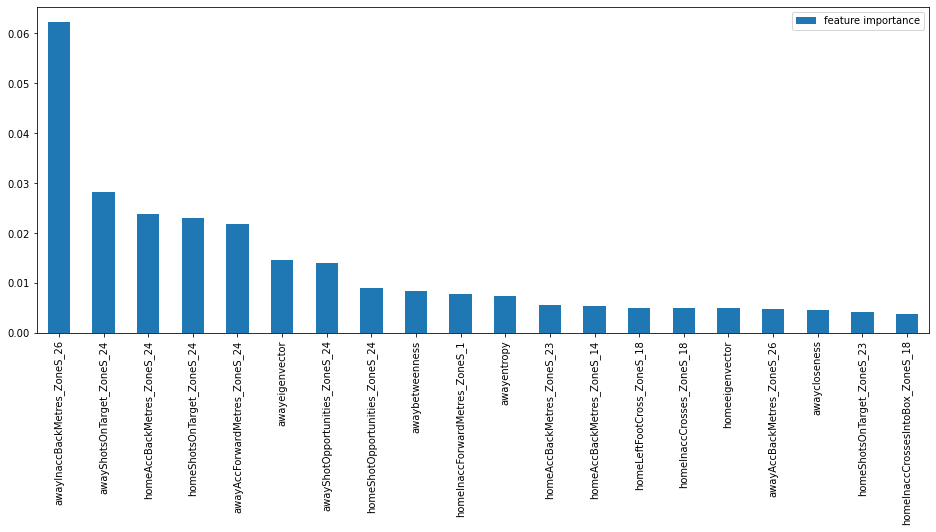

In [210]:
df_feature_importance[0:20].plot(kind='bar')



## fdnn

In [211]:
X_test2 = [tree.predict(X_test) for tree in clf.estimators_]
X_test2 = np.transpose(X_test2)
X_train2 = [tree.predict(X_train) for tree in clf.estimators_]
X_train2 = np.transpose(X_train2)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

In [212]:
# x_total = [tree.predict(result) for tree in clf.estimators_]
# x_total = np.transpose(x_total)

In [213]:
def X_transform(X):
    df = []  
    for sample in X:
        s = []
        for feature in sample:
            if feature == 2:
                s.append([0, 0, 1])
            elif feature == 1:
                s.append([0, 1, 0])
            else:
                s.append([1, 0, 0])
        df.append(s)
    df = np.array(df)
    return df

In [214]:
X_train2 = X_transform(X_train2)
X_test2 = X_transform(X_test2)

In [215]:
X_train2.shape
X_test2.shape

(366, 500, 3)

In [216]:
## one-hot encode the labels
def y_transform(Y):
    df = []
    for l in Y:
        if l == 1:
            df.append([0, 0, 1])
        elif l == 0:
            df.append([0, 1, 0])
        else:
            df.append([1, 0, 0])
    df = np.array(df,dtype=int)
    return df

In [217]:
y_train2 = y_transform(y_train)
y_test2 = y_transform(y_test)

In [218]:
print(y_train2.shape)
print(y_test2.shape)

(1460, 3)
(366, 3)


In [219]:
# X_train2, X_test3, y_train2, y_test3 = train_test_split(X_train2, y_train2, test_size=0.2)


In [220]:
print(y_train2.shape)
print(X_train2.shape)


(1460, 3)
(1460, 500, 3)


In [221]:
# Model

# # Define per-fold score containers
# acc_per_fold = []
# loss_per_fold = []

# kfold = KFold(n_splits=3, shuffle=True)

# fold_no=1

# for train, test in kfold.split(X_train2, y_train2):
def create_model(learning_rate = 0.0001):
    model = Sequential()
    model.add(Flatten(input_shape=(500,3)))
    model.add(Dense(256, activation='relu', kernel_initializer = 'he_normal' ,input_shape=(500*3,)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu',kernel_initializer = 'he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu',kernel_initializer = 'he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax',kernel_initializer = 'he_normal'))
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


    
#     # Generate generalization metrics
#     scores = model.evaluate(X_train2[test], y_train2[test], verbose=0)
#     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])
#     # Increase fold number
#     fold_no = fold_no + 1

In [222]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [223]:
# For Aggs- best 0.966438 using batch_size = 64, epochs = 5000, learning_rate = 0.0001

In [224]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [225]:
model.fit(X_train2, y_train2, batch_size = 64, epochs = 5000, verbose =0)

In [226]:
model.score(X_test2,y_test2)

0.6420764923095703

###### XGBoost DNN

In [227]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [228]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.0001,0.001, 0.01, 0.02,0.1, 0.2, 0.3],
        'n_estimators': [100,200,500,1000]
        }

In [229]:
import datetime
from datetime import *

In [230]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [231]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [232]:
##### CREATE XGB WITH OPTIMIZED PARAMS
# Best hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1.5, 'colsample_bytree': 0.8}

xgb = XGBClassifier(features_names=X_all.columns, gamma=1.5, n_estimators =500, max_depth=7, min_child_weight=5)
xgb.fit(X_train, y_train)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "features_names" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              features_names=Index(['homeAccBackMetres_ZoneS_1', 'awayAccBackMetres_ZoneS_1',
       'homeAccBackMetres_ZoneS_2', 'awayAccBackMetres_ZoneS_2',
       'homeAccBackMetres_ZoneS_3', 'awayAccBackMetres_ZoneS_3',
       'homeAccBackMetres_ZoneS_4', 'aw...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [233]:
# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 67.21%


In [234]:
allDone()

In [669]:
rf = [47.81,50.55,50.55,52.73, 52.46, 53.28, 53.28, 54.10, 54.37]
fdnn = [45.63,52.46,51.91,51.91, 55.19, 52.18, 57.10, 62.56, 65.03]
xgb = [43.99,46.17,53.55,54.92, 57.10, 59.56, 61.48, 65.03, 67.21]

[43.99, 46.17, 53.55, 54.92, 55.19, 57.38, 60.93, 62.84, 64.21]

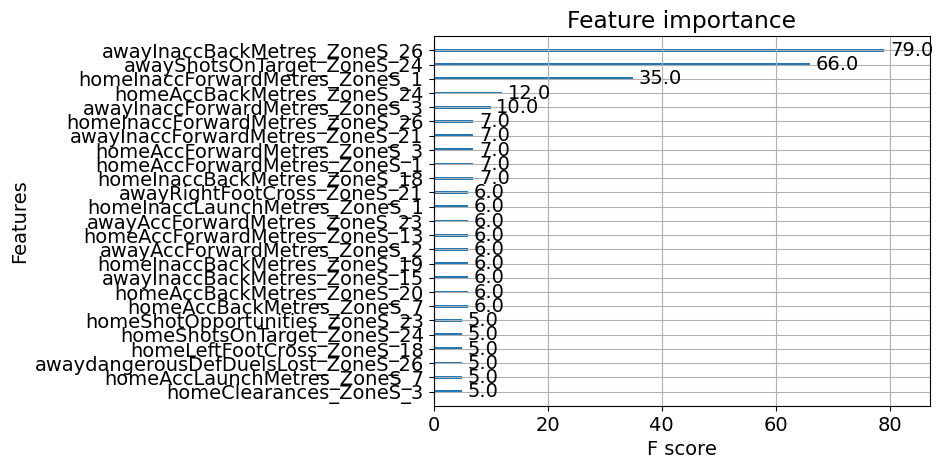

<Figure size 500x500 with 0 Axes>

In [303]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb, max_num_features=25, ylabel="Features")
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)
plt.show()